------------------------------------------------------------------------
   Open Source Notice
------------------------------------------------------------------------
MIT License
Copyright (c) [2023] [Brandon Torrigino]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

------------------------------------------------------------------------
**Author**: Brandon Torrigino  
**Date**: May 29th, 2023

This code is an open source project licensed under the MIT License. 

**Description**:

This code provides implementations for training a Q-learning agent to navigate a maze environment. 
The `MazeEnvironment` class represents the maze environment with an agent and a goal state, while the `QLearningAgent` class implements the Q-learning algorithm for training the agent. The `Train_Agent` class handles coordination for the training of agents and calling support function which include functionality for saving and loading Q-tables, generating videos of trials, exporting a history of run histories, and plotting run results.

For more information, please visit: [URL or additional details]

------------------------------------------------------------------------


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import re

In [58]:
maze_number = 7
num_episodes = 10 # Number of training episodes. Large return for large amount.
max_steps = 500 # Maximum number of steps per episode. Low return for large amount.
explore_rate = 0.8 # Exploration rate: 0 = Exploit only (less random), 1 = Explore only (more random)
learn_rate = 0.3 #  0 relies solely on previous experiences, 1 focuses only on new experiences.
discount = 0.9 # Discount factor: High discount factor places more emphasis on long-term rewards.
save_rate = 2 # Save one out of every number of successful runs specified. 
starting_q_table_dir = "starting_q_tables"
starting_q_table_file = "q_table_episode_6369_maze_7.npy"  #To do a fresh reun set q_table_checkpoint_file

In [59]:
# Declare global variables
global_rewards = []
global_exploration_rates = []
global_episode_count = 0
global_steps_per_episode = []
global_is_success = []

# Construct the full path to the starting Q-table file
####To do a fresh run, comment out below line and uncomment the one below it, this will ignore imported files.
q_table_checkpoint_file = os.path.join(starting_q_table_dir, starting_q_table_file)
#q_table_checkpoint_file = None


In [60]:
import numpy as np

def read_maze_from_file(file_path, maze_variable):
    with open(file_path, 'r') as file:
        lines = file.readlines()

        for i in range(len(lines)):
            if lines[i].strip().startswith(maze_variable):
                maze_str = ''
                j = i

                while j < len(lines) and not lines[j].strip().endswith(']'):
                    maze_str += lines[j]
                    j += 1

                # Execute the maze string as Python code to create the maze array
                exec(maze_str, globals())
                maze = eval(maze_variable)
                return np.array(maze)

    return None

# Set the maze variable
maze_variable = f'maze_{maze_number}'

# Read the maze from the file
maze = read_maze_from_file('mazes.txt', maze_variable)

# Check if the maze was found
if maze is not None:
    print(f"Maze {maze_variable} found in the file.")
    print(maze)
else:
    print(f"Maze {maze_variable} not found in the file.")


Maze maze_7 found in the file.
[['#' 'S' '#' '#' '#' ' ' '#' ' ' '#' '#' '#' ' ' '#' '#' '#' '#' ' ' '#'
  '#' '#']
 ['#' ' ' ' ' '#' ' ' ' ' '#' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '#' ' ' '#'
  '#' '#']
 ['#' '#' ' ' ' ' '#' '#' '#' ' ' ' ' '#' ' ' '#' ' ' ' ' '#' ' ' '#' ' '
  '#' '#']
 ['#' '#' ' ' '#' '#' ' ' ' ' ' ' '#' ' ' ' ' ' ' '#' ' ' '#' ' ' '#' ' '
  ' ' '#']
 ['#' ' ' ' ' ' ' ' ' ' ' ' ' '#' '#' ' ' '#' ' ' ' ' ' ' '#' ' ' '#' ' '
  '#' '#']
 ['#' ' ' '#' '#' '#' ' ' '#' '#' '#' '#' ' ' '#' ' ' '#' '#' ' ' '#' ' '
  '#' '#']
 ['#' ' ' ' ' '#' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '#' ' ' ' '
  ' ' '#']
 ['#' '#' '#' '#' '#' ' ' '#' '#' '#' '#' '#' '#' ' ' '#' ' ' '#' ' ' '#'
  '#' '#']
 ['#' '#' ' ' ' ' ' ' ' ' ' ' ' ' '#' ' ' ' ' '#' ' ' '#' ' ' '#' ' ' '#'
  '#' '#']
 ['#' '#' ' ' '#' '#' '#' '#' '#' '#' '#' '#' '#' ' ' ' ' ' ' ' ' ' ' ' '
  ' ' '#']
 ['#' '#' ' ' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#'
  ' ' ' ']
 ['#' ' ' ' ' '#' '#' ' ' '#' ' ' 

In [61]:
class MazeEnvironment:
    def __init__(self, maze):
        self.maze = maze
        self.agent_position = None
        self.goal_state = None
        self.actions = {
            'up': (-1, 0),
            'down': (1, 0),
            'left': (0, -1),
            'right': (0, 1)
        }

    def reset(self):
        self.agent_position = np.argwhere(self.maze == 'S')[0]
        self.goal_state = np.argwhere(self.maze == 'G')[0]

    def step(self, action):
        new_position = self.agent_position + self.actions[action]
        if self.is_valid_move(new_position):
            self.agent_position = new_position

    def is_valid_move(self, position):
        return (
            position[0] >= 0 and position[0] < self.maze.shape[0] and
            position[1] >= 0 and position[1] < self.maze.shape[1] and
            self.maze[tuple(position)] != '#'
        )

    def is_goal_state(self):
        return np.array_equal(self.agent_position, self.goal_state)

    def get_state(self):
        if self.agent_position is not None:
            return np.ravel_multi_index(self.agent_position, self.maze.shape)
        else:
            return 0  # Return a default state when agent_position is not set

    def render(self):
        maze_copy = np.where(self.maze == '#', 1, 0)
        maze_copy[tuple(self.agent_position)] = 2
        maze_copy[tuple(self.goal_state)] = 3
        return maze_copy


In [62]:
import os
import matplotlib.pyplot as plt

def plot_training_results(rewards, exploration_rates, episode_count, steps_per_episode, is_success):
    # Create a tiled plot
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot rewards per episode
    axs[0, 0].plot(range(1, episode_count + 1), rewards)
    axs[0, 0].set_xlabel('Episode')
    axs[0, 0].set_ylabel('Reward')
    axs[0, 0].set_title('Rewards per Episode')

    # Plot exploration rate per episode
    axs[0, 1].plot(range(1, episode_count + 1), exploration_rates)
    axs[0, 1].set_xlabel('Episode')
    axs[0, 1].set_ylabel('Exploration Rate')
    axs[0, 1].set_title('Exploration Rate per Episode')

    # Plot steps per episode
    axs[1, 0].plot(range(1, episode_count + 1), steps_per_episode)
    axs[1, 0].set_xlabel('Episode')
    axs[1, 0].set_ylabel('Steps')
    axs[1, 0].set_title('Steps per Episode')

    # Calculate total episodes
    total_episodes = episode_count + (len(is_success) - episode_count)

    # Plot success per episode
    axs[1, 1].plot(range(1, total_episodes + 1), is_success)
    axs[1, 1].set_xlabel('Episode')
    axs[1, 1].set_ylabel('Failure (0) / Success (1)')
    axs[1, 1].set_title('Success per Episode')

    # Adjust spacing between subplots
    fig.tight_layout()

    # Define the plot file name and path
    plot_dir = 'run_history'
    plot_file = 'run_1_plot.jpg'
    plot_path = os.path.join(plot_dir, plot_file)

    # Check if the plot file already exists
    if os.path.exists(plot_path):
        # Find the next available plot number
        plot_number = 1
        while True:
            plot_number += 1
            new_plot_file = f'run_{plot_number}_plot.jpg'
            new_plot_path = os.path.join(plot_dir, new_plot_file)
            if not os.path.exists(new_plot_path):
                break
        plot_file = new_plot_file
        plot_path = new_plot_path

    # Save the figure as a JPEG image with the unique plot file name
    plt.savefig(plot_path)

    # Show the plot
    plt.show()


In [63]:
class QLearningAgent:
    def __init__(self, num_states, num_actions, num_episodes, learning_rate=learn_rate, discount_factor=discount, exploration_rate=explore_rate):
        self.num_states = num_states
        self.num_actions = num_actions
        self.num_episodes = num_episodes
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.q_table = np.zeros((num_states, num_actions))

    def get_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return np.random.randint(self.num_actions)
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, next_state, reward):
        current_q = self.q_table[state, action]
        max_next_q = np.max(self.q_table[next_state])
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[state, action] = new_q

    def update_exploration_rate(self, episode):
        #exploration_rate = max(0.01, 1.0 - (episode / self.num_episodes))
        exploration_rate = max(learn_rate, explore_rate - (episode / self.num_episodes))
        self.exploration_rate = exploration_rate

    def save_q_table(self, file_path):
        np.save(file_path, self.q_table)

    def load_q_table(self, file_path):
        self.q_table = np.load(file_path)


In [64]:
####If you want to see the q-table then run this with the q-table of interest in the script directory

#import numpy as np
#q_table = np.load('q_table_episode_1.npy')
#print(q_table)

In [65]:
def load_or_initialize_q_table_checkpoint(agent, q_table_checkpoint_file):
    if q_table_checkpoint_file is not None and os.path.exists(q_table_checkpoint_file):
        # Load the existing Q-table checkpoint
        agent.load_q_table(q_table_checkpoint_file)
        print(f"Loaded Q-table checkpoint from {q_table_checkpoint_file}")
    else:
        # Create the Q-table checkpoint folder if it doesn't exist
        q_table_checkpoint_dir = "maze_q_tables"
        os.makedirs(q_table_checkpoint_dir, exist_ok=True)

        # Save the Q-table after the first episode step
        q_table_filename = f"q_table_episode_1.npy"
        q_table_path = os.path.join(q_table_checkpoint_dir, q_table_filename)
        agent.save_q_table(q_table_path)
        print(f"Saved Initial Q-table checkpoint to {q_table_path}")


In [66]:
import os
import matplotlib.pyplot as plt

save_count = 0

def save_frames(frames, episode):
    global save_count

    save_count += 1

    if save_count % save_rate != 0:
        return

    folder_path = f"frames/episode_{episode:03d}"
    os.makedirs(folder_path, exist_ok=True)

    for i, frame in enumerate(frames):
        frame_path = f"{folder_path}/step_{i:03d}.png"
        plt.imshow(frame, cmap='gray', interpolation='nearest')
        plt.axis('off')
        plt.savefig(frame_path)
        plt.close()


In [67]:
def save_q_table_checkpoint(agent, episode,num_episodes):
    q_table_checkpoint_dir = "maze_q_tables"
    os.makedirs(q_table_checkpoint_dir, exist_ok=True)
    q_table_filename = f"q_table_episode_{episode}.npy"
    q_table_path = os.path.join(q_table_checkpoint_dir, q_table_filename)
    agent.save_q_table(q_table_path)
    decile_range = round(num_episodes / 10)  # Calculate the range for each decile
    deciles = np.arange(decile_range, num_episodes + decile_range, decile_range)

    if episode in deciles:
        print(f"Saved Q-table checkpoint to {q_table_path}")


In [68]:
def train_agent(maze, agent, num_episodes, max_steps, run_history_file, q_table_checkpoint_file=q_table_checkpoint_file):
    rewards = []
    exploration_rates = []
    completed_episodes = 0
    steps_per_episode = []
    is_success = []

    load_or_initialize_q_table_checkpoint(agent, q_table_checkpoint_file)

    for episode in range(num_episodes):
        #print(f"Training Episode: {episode + 1}/{num_episodes}")
        env = MazeEnvironment(maze)
        env.reset()
        total_reward = 0
        goal_reached = False
        steps = 0
        frames = []  # Initialize frames list for the current episode
        prev_position = None  # Initialize prev_position

        for step in range(max_steps):
            state = env.get_state()
            action = agent.get_action(state)
            env.step(list(env.actions.keys())[action])
            steps += 1

            if env.is_goal_state():
                reward = 100
                goal_reached = True
                break

            if prev_position is not None and not np.array_equal(env.agent_position, prev_position):
                frames.append(env.render())

            prev_position = env.agent_position

            reward = -1
            total_reward += reward
            next_state = env.get_state()
            agent.update_q_table(state, action, next_state, reward)

        # Update exploration rate based on the episode number
        agent.update_exploration_rate(episode)

        if goal_reached:
            rewards.append(total_reward)
            completed_episodes += 1
            exploration_rates.append(agent.exploration_rate)
            steps_per_episode.append(steps)
            save_frames(frames, episode)

        episode_data = {
            'maze_number': maze_number,
            'num_episodes': num_episodes,
            'current_episode': episode + 1,
            'max_steps': max_steps,
            'steps_for_success': steps if goal_reached else -1,
            'starting_exploration_rate': explore_rate,
            'current_exploration_rate': agent.exploration_rate,
            'learning_rate': learn_rate,
            'discount_rate': discount,
            'is_success': int(goal_reached)
        }

        # Append the is_success value for each episode
        is_success.append(int(goal_reached))

        # Read the most recent run history file
        run_history = pd.read_excel(run_history_file)

        # Concatenate the episode data with the run history
        episode_df = pd.DataFrame([episode_data])
        run_history = pd.concat([run_history, episode_df], ignore_index=True)

        # Save the updated run history to the file
        run_history.to_excel(run_history_file, index=False)

        # Save the Q-table after each episode
        save_q_table_checkpoint(agent, episode,num_episodes)

    episode_count = len(rewards)  # Calculate the episode count

    if rewards:
        # plot_training_results(rewards, exploration_rates, episode_count, steps_per_episode, is_success)
        # Assign the results to the global variables
        global global_rewards
        global global_exploration_rates
        global global_episode_count
        global global_steps_per_episode
        global global_is_success

        global_rewards = rewards
        global_exploration_rates = exploration_rates
        global_episode_count = episode_count
        global_steps_per_episode = steps_per_episode
        global_is_success = is_success
    else:
        print("No training results available.")

In [69]:
import pandas as pd
import os

# Create the run_history folder if it doesn't exist
run_history_folder = "run_history"
if not os.path.exists(run_history_folder):
    os.makedirs(run_history_folder)

# Determine the next available run history file name
existing_files = [file for file in os.listdir(run_history_folder) if file.startswith("run_") and file.endswith(".xlsx")]
suffix = ""
file_count = 1
while f"run_{file_count}_history{suffix}.xlsx" in existing_files:
    suffix = f"_{file_count}"
    file_count += 1

# Define the run history file path
run_history_file = os.path.join(run_history_folder, f"run_{file_count}_history{suffix}.xlsx")

# Create the run history file if it doesn't exist
if not os.path.exists(run_history_file):
    run_history = pd.DataFrame(columns=['maze_number', 'num_episodes', 'current_episode', 'max_steps',
                                        'steps_for_success', 'starting_exploration_rate', 'current_exploration_rate',
                                        'learning_rate', 'discount_rate', 'is_success'])
    run_history.to_excel(run_history_file, index=False)


In [70]:
# Define and train the agent
agent = QLearningAgent(np.prod(maze.shape), len(MazeEnvironment(maze).actions.keys()), num_episodes=num_episodes)
rewards = train_agent(maze, agent, num_episodes=num_episodes, max_steps=max_steps, run_history_file=run_history_file)


Loaded Q-table checkpoint from starting_q_tables/q_table_episode_6369_maze_7.npy
Saved Q-table checkpoint to maze_q_tables/q_table_episode_1.npy
Saved Q-table checkpoint to maze_q_tables/q_table_episode_2.npy
Saved Q-table checkpoint to maze_q_tables/q_table_episode_3.npy
Saved Q-table checkpoint to maze_q_tables/q_table_episode_4.npy
Saved Q-table checkpoint to maze_q_tables/q_table_episode_5.npy
Saved Q-table checkpoint to maze_q_tables/q_table_episode_6.npy
Saved Q-table checkpoint to maze_q_tables/q_table_episode_7.npy
Saved Q-table checkpoint to maze_q_tables/q_table_episode_8.npy
Saved Q-table checkpoint to maze_q_tables/q_table_episode_9.npy


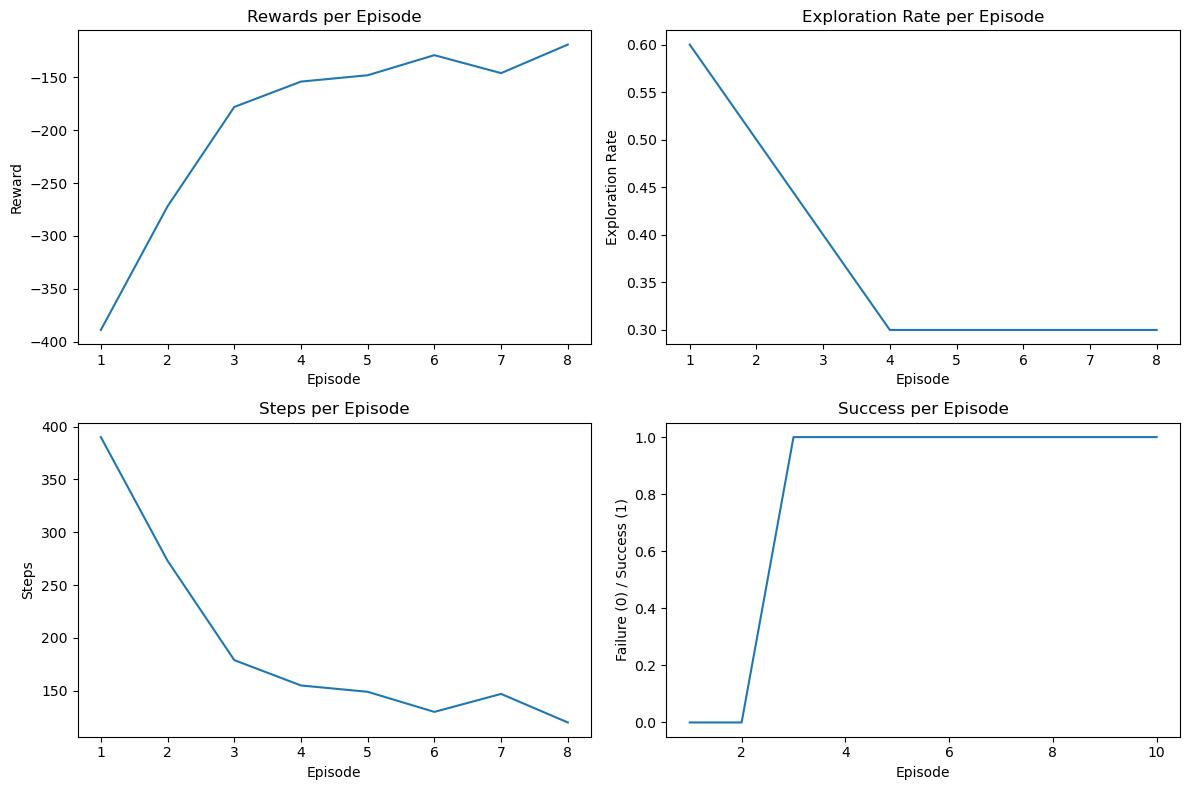

In [71]:
# Call the plot_training_results function

plot_training_results(global_rewards, global_exploration_rates, global_episode_count, global_steps_per_episode, global_is_success)


In [72]:
####NOT IMPLEMENTED YET, READ RUN HISTORY FROM HISTORY FILES AND COMPARE WITH A NEW PLOT FUNCTION
###ETHIS WILL MAYBE ACT AS IMPORT FUNCTION

import pandas as pd
import matplotlib.pyplot as plt
import os

def read_run_history(run_history_folder):
    # Get the list of files in the run_history folder
    files = os.listdir(run_history_folder)

    # Filter only Excel files
    excel_files = [file for file in files if file.endswith('.xlsx')]

    if not excel_files:
        print("No run history files found.")
        return None

    # Sort the files based on creation time
    excel_files.sort(key=lambda x: os.path.getctime(os.path.join(run_history_folder, x)), reverse=True)

    # Select the most recent file
    run_history_file = os.path.join(run_history_folder, excel_files[0])

    # Read the run history file and retrieve the training data
    episode_data = pd.DataFrame(columns=['maze_number', 'num_episodes', 'current_episode', 'max_steps',
                                         'steps_for_success', 'starting_exploration_rate', 'current_exploration_rate',
                                         'learning_rate', 'discount_rate', 'is_success'])
    run_history = pd.read_excel(run_history_file)
    run_history = pd.concat([run_history, episode_data], ignore_index=True)
   
    return run_history


In [73]:
#### NOT IMPLEMENTED/FINISHED YET, SEARCH RUN HISTORY FOR BEST RUN AND SAVE ITS QTABLE IN ANOTHER FOLDER.
#### WILL DELETE THE UNNECESSARY FILES
### MAY BE EDITED TO IMPLEMENT THE NEWLY SAVED BEST RUNS FILES FOR THE NEXT RUN.

import os
import shutil

def cleanup_q_tables(run_folder, run_history_df, num_keep=2):
    # Create the 'best_q_tables' subdirectory if it doesn't exist
    best_q_tables_dir = os.path.join(run_folder, "best_q_tables")
    os.makedirs(best_q_tables_dir, exist_ok=True)

    # Filter the run history DataFrame to retain only successful episodes with steps_for_success > 0
    successful_episodes = run_history_df[(run_history_df['is_success'] == 1) & (run_history_df['steps_for_success'] > 0)]

    # Group the successful episodes by maze number
    maze_groups = successful_episodes.groupby('maze_number')

    for maze_number, group in maze_groups:
        # Sort the group by steps for success in ascending order
        sorted_group = group.sort_values('steps_for_success')

        # Select the best Q-table files to retain
        best_files = sorted_group.head(num_keep)

        for index, row in best_files.iterrows():
            # Get the episode number and corresponding Q-table filename
            episode_number = row['current_episode']
            q_table_filename = f"q_table_episode_{episode_number}.npy"

            # Determine the Q-table file path
            q_table_file_path = os.path.join(run_folder, q_table_filename)

            # Determine the destination filename with maze number and steps taken
            dest_filename = f"maze_{maze_number}_steps_{row['steps_for_success']}_{q_table_filename}"

            # Determine the destination path in the 'best_q_tables' subdirectory
            dest_path = os.path.join(best_q_tables_dir, dest_filename)

            # Copy the Q-table file to the 'best_q_tables' subdirectory
            shutil.copy(q_table_file_path, dest_path)

    # Remove all remaining Q-table files in the run folder
    for filename in os.listdir(run_folder):
        if filename.startswith("q_table_episode_"):
            file_path = os.path.join(run_folder, filename)
            os.remove(file_path)

    print(f"Cleanup complete. Best Q-tables saved in '{best_q_tables_dir}'.")


#cleanup_q_tables("maze_q_tables", run_history, num_keep=2)


In [74]:
import os
import cv2

def generate_movie(episode_folder):
    episode = int(episode_folder.split("_")[-1])

    output_path = f"{episode_folder}.mp4"

    if os.path.exists(output_path):
        print(f"Movie already exists for episode {episode}. Skipping movie generation.")
        return False

    images = []
    for filename in sorted(os.listdir(episode_folder)):
        if filename.endswith(".png"):
            file_path = os.path.join(episode_folder, filename)
            images.append(cv2.imread(file_path))

    if not images:
        print(f"No images found in episode {episode} folder. Skipping movie generation.")
        return False

    height, width, _ = images[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, 10.0, (width, height))

    for frame in images:
        out.write(frame)

    out.release()

    print(f"Movie generated for episode {episode}.")
    return True

def generate_movies_recursive(folder_path):
    if not os.path.exists(folder_path):
        print("No new movies were created.")
        return

    folders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    if not folders:
        print("Agent couldn't find the exit in any remaining episodes.")
        return

    new_movies_generated = False  # Flag to track if any new movies were generated

    for episode_folder in folders:
        episode_folder_path = os.path.join(folder_path, episode_folder)
        if generate_movie(episode_folder_path):
            new_movies_generated = True

    if not new_movies_generated:
        print("Agent couldn't find the exit in any remaining episodes.")
    else:
        generate_movies_recursive(folder_path)

generate_movies_recursive("frames")


Movie generated for episode 3.
Movie generated for episode 5.
Movie generated for episode 7.
Movie generated for episode 9.
Movie already exists for episode 3. Skipping movie generation.
Movie already exists for episode 5. Skipping movie generation.
Movie already exists for episode 7. Skipping movie generation.
Movie already exists for episode 9. Skipping movie generation.
Agent couldn't find the exit in any remaining episodes.
